# Project Title
### Data Engineering Capstone Project

#### Project Summary
The objective of this project is to build an analytics database for detecting relation between temperature and air quality and electric vehicles sellings all over the world and specifically in Europe.

This database will be helpful to find answers for questions such as:

* How has weather and air quality in Europe changed over the years?

* What are the countries with more electric vehicles? Has the air a better quality?


The project follows the follow steps:
* Step 1: Scope the Project and Gather Data
* Step 2: Explore and Assess the Data
* Step 3: Define the Data Model
* Step 4: Run ETL to Model the Data
* Step 5: Complete Project Write Up

In [2]:
! pip install -U pandasql

  Running setup.py bdist_wheel for pandasql ... done
  Stored in directory: /root/.cache/pip/wheels/53/6c/18/b87a2e5fa8a82e9c026311de56210b8d1c01846e18a9607fc9
Successfully built pandasql


In [3]:
! pip install -U  plotly

    100% |████████████████████████████████| 15.6MB 3.2MB/s eta 0:00:01
  Found existing installation: plotly 2.0.15
    Uninstalling plotly-2.0.15:
      Successfully uninstalled plotly-2.0.15


In [4]:
! pip install -U  missingno

In [5]:
# Do all imports and installs here
import os
import configparser
import pandas as pd
import numpy as np
from datetime import datetime 
import missingno as msno
from pandas.io.json import json_normalize #package for flattening json in pandas df
from pandasql import sqldf

from pyspark.sql import SparkSession, SQLContext, GroupedData, HiveContext
import pyspark.sql.functions as funcs
from pyspark.sql.functions import isnan, when, count, col, sum, udf, dayofmonth, dayofweek, month, year, weekofyear, avg, monotonically_increasing_id
from pyspark.sql.functions import year, month, dayofweek, dayofmonth, weekofyear, date_format
from pyspark.sql.functions import *
from pyspark.sql.functions import date_add as d_add
from pyspark.sql.functions import lit
from pyspark.sql.types import *
from pyspark.sql.types import DoubleType, StringType, IntegerType, FloatType
from pyspark.sql import functions as F
from pyspark.sql import Row
from pyspark.sql import functions as F
from pyspark.sql import types as T
from pyspark.sql import Window as W

import json 
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px

import utils as utils

pd.set_option('display.width',170, 'display.max_rows',200, 'display.max_columns',900)

In [6]:
config = configparser.ConfigParser()
config.read('config.cfg')

os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["PATH"] = "/opt/conda/bin:/opt/spark-2.4.3-bin-hadoop2.7/bin:/opt/conda/bin:/usr/local/sbin:/usr/local/bin:/usr/sbin:/usr/bin:/sbin:/bin:/usr/lib/jvm/java-8-openjdk-amd64/bin"
os.environ["SPARK_HOME"] = "/opt/spark-2.4.3-bin-hadoop2.7"
os.environ["HADOOP_HOME"] = "/opt/spark-2.4.3-bin-hadoop2.7"
os.environ['AWS_ACCESS_KEY_ID']=config['AWS']['AWS_ACCESS_KEY_ID']
os.environ['AWS_SECRET_ACCESS_KEY']=config['AWS']['AWS_SECRET_ACCESS_KEY']

### Create a spark session

In [7]:
MAX_MEMORY = '30G'

spark = SparkSession.builder\
        .config("spark.jars.repositories", "https://repos.spark-packages.org/")\
        .config("spark.jars.packages", "org.apache.hadoop:hadoop-aws:2.7.0,saurfang:spark-sas7bdat:2.0.0-s_2.11")\
        .enableHiveSupport().getOrCreate()

### Step 1: Scope the Project and Gather Data

#### Scope 
Explain what you plan to do in the project in more detail. What data do you use? What is your end solution look like? What tools did you use? etc>
The objective of this project is to build an analytics database for detecting a relation between temperature, air quality and electric vehicles sellings all over the world and specifically in Europe.

This database will be helpful to find answers for questions such as:

- How has weather and air quality in Europe changed over the years?
- What are the countries with more electric vehicles? 
- Has the air a better quality in the countries with more electric vehicles?
- Is there a relation between the longevity and the number of electric vehicles in a country?

#### Describe and Gather Data 
Describe the data sets you're using. Where did it come from? What type of information is included? 
This project pulls data from several sources and create a star schema with some facts and dimensional tables.
The datasets used for this project are:
- GlobalLandTemperatures from Udacity 
- Air Quality from Opendatasoft
- Electric Vehicles Sellings from IEA 
- World Population Data from https://www.worlddata.info/

This Capstone project will have the following steps:
1. Use Spark to load the datasets into dataframes
2. An Exploratory data analysis EDA to explore all the dataset details
3. Perform some cleaning on all the datasets
4. Prepare the dimensional and facts tables

The technology used is AWS S3 buckets where the source data resides, then the data will be staged and processed with Spark.


## Temperature Data

### Let's load the Global Land Temperatures by city dataset


In [8]:
# Let's load the temperature data
file_temp = '../../data2/GlobalLandTemperaturesByCity.csv'
df_temp  = spark.read.csv(file_temp, inferSchema=True, header=True, sep=',')

#### And view the dataset in its raw format

In [ ]:
df_temp.show()

In [ ]:
# I prefer this view with Pandas
df_temp.limit(5).toPandas()

#### Now we are going to print the schema of the temperature raw dataset

In [ ]:
df_temp.printSchema()

## AIR QUALITY DATASET 

### Let's load the Dataset Air Quality by city dataset

#### I am going to use a dataset of air quality, so first let's analyse it

In [9]:
# Let's read the file
df_aq = pd.read_json("openaq.json")

In [ ]:
# Let's have some basic description of the dataset
df_aq.info()

In [ ]:
# Let's have an overview of this dataset
df_aq.describe()

In [ ]:
# Let's see an example of the data
df_aq.head()

## ELECTRIC VEHICLE SELLINGS

## Let's load this dataset

In [10]:
# Load the csv file
df_el = pd.read_csv("./IEA-EV-data.csv")

In [ ]:
# Let's get the basic info of this dataset
df_el.info()

In [ ]:
# Let's see the first lines of the dataset
df_el.head()

In [ ]:
df_el.info()

## Let's load the World Population dataset

In [11]:
df_population = pd.read_csv("./world_population.csv")

In [ ]:
df_population.head()

In [ ]:
# Let's have an overview of this dataset
df_population.info()

In [ ]:
# Let's see a summary of this dataset
df_population.describe()

### Step 2: Explore and Assess the Data
#### Explore the Data 
Identify data quality issues, like missing values, duplicate data, etc.

#### Cleaning Steps
Document steps necessary to clean the data

In [ ]:
# Performing cleaning tasks here

### Cleaning the Global World Temperature Dataset 

In [ ]:
# Now we are going to check the null values on the Temperature dataset
df_temp.select(*(sum(col(c).isNull().cast("int")).alias(c) for c in df_temp.columns)).show()

In [12]:
# As we have several null values in AverageTemperature and AverageTemperatureUncertaninty columns 
# we are going to remove those rows
# We could impute with a media/median value, but we don't need such a level of detail for the purpose of this project
df_clean_temp = df_temp.na.drop(how="any")

In [ ]:
# And check the first 5 lines of the dataset without null values...
df_clean_temp.limit(5).toPandas()

In [ ]:
# Let's check the number of rows after dropping nulls (yet more than 8 million rows)
df_clean_temp.count()

### Cleaning the Air Quality Dataset 

In [ ]:
df_aq.count()

In [ ]:
# Now we are going to ckeck null in the Air Quality datasets
df_aq.isna().sum().sum()

In [ ]:
# With this matrix, we can locate where the nulls are: city and country_name are the fields with more missing values
msno.matrix(df_aq, figsize=(20,5), labels=True, fontsize=10)

In [13]:
# We are going to fill some country field
df_aq.loc[df_aq["country"] == "CN", "city"] = "Shanghai"
df_aq.loc[df_aq["country"] == "IN", "city"] = "Mumbai"
df_aq.loc[df_aq["country"] == "CO", "city"] = "Bogota"
df_aq.loc[df_aq["country"] == "FR", "city"] = "Paris"
df_aq.loc[df_aq["country"] == "MX", "city"] = "Mexico"
df_aq.loc[df_aq["country"] == "IL", "city"] = "Tel Aviv"
df_aq.loc[df_aq["country"] == "DE", "city"] = "Berlin"
df_aq.loc[df_aq["country"] == "IT", "city"] = "Rome"
df_aq.loc[df_aq["country"] == "ES", "city"] = "Madrid"
df_aq.loc[df_aq["country"] == "AT", "city"] = "Austria"
df_aq.loc[df_aq["country"] == "CZ", "city"] = "Prague"
df_aq.loc[df_aq["country"] == "EC", "city"] = "Quito"
df_aq.loc[df_aq["country"] == "AU", "city"] = "Sydney"
df_aq.loc[df_aq["country"] == "GB", "city"] = "London"
df_aq.loc[df_aq["country"] == "EE", "city"] = "Tallinn"
df_aq.loc[df_aq["country"] == "CA", "city"] = "Toronto"
df_aq.loc[df_aq["country"] == "HR", "city"] = "Zagreb"
df_aq.loc[df_aq["country"] == "MN", "city"] = "Ulaanbaatar"
df_aq.loc[df_aq["country"] == "NO", "city"] = "Oslo"
df_aq.loc[df_aq["country"] == "CL", "city"] = "Santiago"
df_aq.loc[df_aq["country"] == "BA", "city"] = "Sarajevo"
df_aq.loc[df_aq["country"] == "EE", "city"] = "Tallinn"
df_aq.loc[df_aq["country"] == "BE", "city"] = "Sofia"
df_aq.loc[df_aq["country"] == "BD", "city"] = "Daca"
df_aq.loc[df_aq["country"] == "NL", "city"] = "Amsterdam"
df_aq.loc[df_aq["country"] == "BR", "city"] = "Brasilia"
df_aq.loc[df_aq["country"] == "HU", "city"] = "Budapest"
df_aq.loc[df_aq["country"] == "FI", "city"] = "Helsinki"
df_aq.loc[df_aq["country"] == "ID", "city"] = "Yakarta"
df_aq.loc[df_aq["country"] == "IS", "city"] = "Reikiavik"
df_aq.loc[df_aq["country"] == "CH", "city"] = "Bern"
df_aq.loc[df_aq["country"] == "DK", "city"] = "Copenhagen"
df_aq.loc[df_aq["country"] == "JO", "city"] = "Amman"
df_aq.loc[df_aq["country"] == "LV", "city"] = "Riga"
df_aq.loc[df_aq["country"] == "MM", "city"] = "Naipyidó"
df_aq.loc[df_aq["country"] == "GR", "city"] = "Athen"
df_aq.loc[df_aq["country"] == "AQ", "city"] = "Bogota"
df_aq.loc[df_aq["country"] == "KE", "city"] = "Nairobi"
df_aq.loc[df_aq["country"] == "IE", "city"] = "Dublin"
df_aq.loc[df_aq["country"] == "LA", "city"] = "Vientiane"
df_aq.loc[df_aq["country"] == "GA", "city"] = "Libreville"
df_aq.loc[df_aq["country"] == "AR", "city"] = "Buenos Aires"
df_aq.loc[df_aq["country"] == "LU", "city"] = "Luxemburgo"
df_aq.loc[df_aq["country"] == "AF", "city"] = "Kabul"

In [ ]:
# Check again the total number of nulls
df_aq.isna().sum().sum()

In [ ]:
# Check where the exact nulls are
df_aq.isna().sum()

In [14]:
# Let's fix some nulls with the city,country and country_name_en fields
df_aq.loc[df_aq["measurements_sourcename"] == "Kosovo", "country_name_en"] = "XK"
df_aq.loc[df_aq["measurements_sourcename"] == "Kosovo", "country"] = "Kosovo"

df_aq.loc[df_aq["measurements_sourcename"] == "Bogota", "country"] = "Colombia"
df_aq.loc[df_aq["measurements_sourcename"] == "Bogota", "country_name_en"] = "CO"

df_aq.loc[df_aq["city"] == "Curacao", "country_name_en"] = "CW"
df_aq.loc[df_aq["city"] == "Curacao", "country"] = "Curacao"

df_aq.loc[df_aq["location"] == "Dushanbe", "country_name_en"] = "TJK"
df_aq.loc[df_aq["location"] == "Dushanbe", "city"] = "Dushanbe"

df_aq.loc[df_aq["location"] == "Baghdad", "country_name_en"] = "IE"
df_aq.loc[df_aq["location"] == "Baghdad", "city"] = "Baghdad"

df_aq.loc[df_aq["location"] == "Baku", "country_name_en"] = "AZN"
df_aq.loc[df_aq["location"] == "Baku", "city"] = "Baku"

df_aq.loc[df_aq["location"] == "Curacao", "country_name_en"] = "CUW"
df_aq.loc[df_aq["location"] == "Curacao", "city"] = "Curacao"

df_aq.loc[df_aq["location"] == "Hanoi", "country_name_en"] = "VN"
df_aq.loc[df_aq["location"] == "Hanoi", "city"] = "Hanoi"

df_aq.loc[df_aq["location"] == "Ashgabat", "country_name_en"] = "TKM"
df_aq.loc[df_aq["location"] == "Ashgabat", "city"] = "Ashgabat"

df_aq.loc[df_aq["location"] == "Sarajevo", "country_name_en"] = "BIH"
df_aq.loc[df_aq["location"] == "Sarajevo", "country"] = "Bosnia-Herzegovina"
df_aq.loc[df_aq["location"] == "Sarajevo", "city"] = "Sarajevo"
df_aq.loc[df_aq["location"] == "Banja Luk", "country"] = "Bosnia-Herzegovina"
df_aq.loc[df_aq["location"] == "Banja Luka", "country_name_en"] = "BIH"
df_aq.loc[df_aq["location"] == "Banja Luka", "city"] = "Banja Luka"

df_aq.loc[df_aq["location"] == "Pristina", "country_name_en"] = "XK"
df_aq.loc[df_aq["location"] == "Pristina", "city"] = "Pristina"
df_aq.loc[df_aq["location"] == "US Diplomatic Post: Pristina", "country_name_en"] = "XK"
df_aq.loc[df_aq["location"] == "US Diplomatic Post: Pristina", "city"] = "Pristina"

df_aq.loc[df_aq["location"] == "Trollhaugen", "country_name_en"] = "NO"
df_aq.loc[df_aq["location"] == "Trollhaugen", "city"] = "Trollhaugen"
df_aq.loc[df_aq["location"] == "Trollhaugen", "country"] = "Norway"

df_aq.loc[df_aq["location"] == "Kuwait City", "country_name_en"] = "KW"
df_aq.loc[df_aq["location"] == "Kuwait City", "city"] = "Kuwait"
df_aq.loc[df_aq["location"] == "Kuwait City", "country"] = "Kuwait"

df_aq.loc[df_aq["location"] == "Colombo", "country_name_en"] = "LK"
df_aq.loc[df_aq["location"] == "Colombo", "city"] = "Colombo"
df_aq.loc[df_aq["location"] == "Colombo", "country"] = "Sri Lanka"

df_aq.loc[df_aq["location"] == "Ho Chi Minh City", "country_name_en"] = "VN"
df_aq.loc[df_aq["location"] == "Ho Chi Minh City", "city"] = "TrollHo Chi Minh City"
df_aq.loc[df_aq["location"] == "Ho Chi Minh City", "country"] = "Vietnam"

In [ ]:
# Check finally: the nulls values are on coordinates field, and that is a field that is not crucial
df_aq.isna().sum()

In [ ]:
df_aq[['city', 'country','country_name_en', 'measurements_lastupdated']].duplicated().count()

### Cleaning the EV Sellings Dataset 

In [ ]:
df_el.info()

In [ ]:
# Now we are going to ckeck null in the Electric Vehicle Sellings datasets --> There are no null values!!!
df_el.isna().sum().sum()

In [ ]:
msno.matrix(df_el, figsize=(20,5), labels=True, fontsize=10);

In [ ]:
# Nothing to clear with this datset
df_el.head()

### Cleaning the Population Dataset 

In [ ]:
# It seems there are no nulls in this dataset
df_population.info()

In [ ]:
# Now we are going to ckeck null in the Population dataset --> There are no null values!!!
df_population.isna().sum().sum()

### Step 3: Define the Data Model
#### 3.1 Conceptual Data Model
Map out the conceptual data model and explain why you chose that model:

--> I have chosen a Star Schema data model

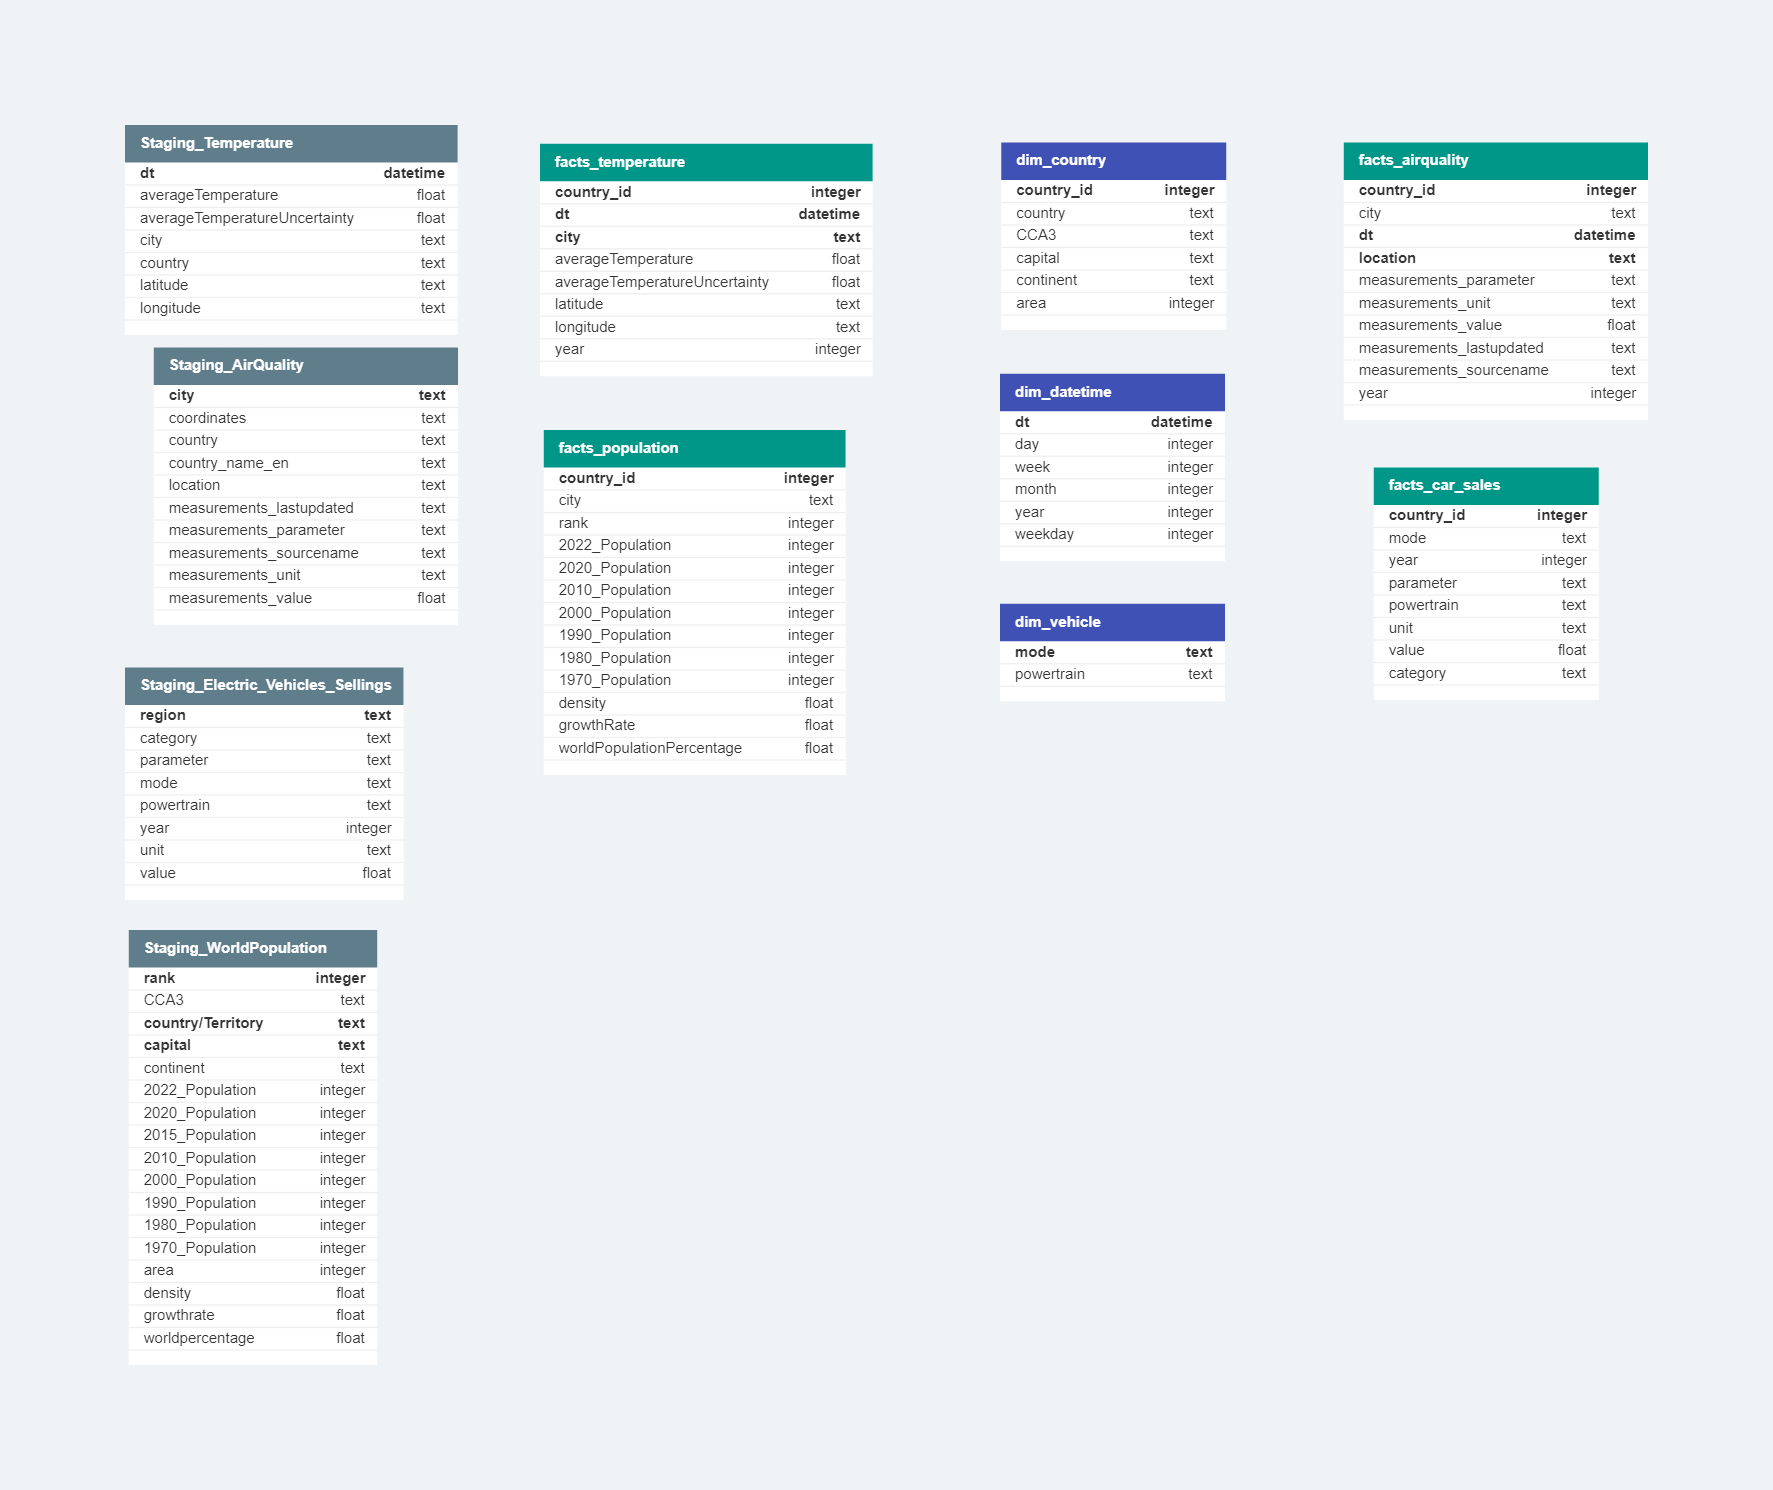

#### 3.2 Mapping Out Data Pipelines
List the steps necessary to pipeline the data into the chosen data model

* 1. Loading the data into staging tables
* 2. Creating dimension tables
* 3. Creating facts tables
* 4. Writing data into parquet files
* 5. Perform some quality checks


### Step 4: Run Pipelines to Model the Data 
#### 4.1 Create the data model
Build the data pipelines to create the data model.

In [15]:
# Now we set the output path where the data will be stored
output_folder = "output/"

### Let's start with the staging tables ...

In [16]:
# get the data from the clean datasets
staging_temperature = df_clean_temp
staging_airquality = df_aq
staging_electric_vehicles_sellings = df_el
staging_world_population = df_population

In [17]:
staging_temperature = staging_temperature.withColumnRenamed("AverageTemperature","averageTemperature") \
    .withColumnRenamed("AverageTemperatureUncertainty","averageTemperatureUncertainty") \
    .withColumnRenamed("City","city") \
    .withColumnRenamed("Country","country") \
    .withColumnRenamed("Latitude","latitude") \
    .withColumnRenamed("Longitude","longitude")

In [ ]:
staging_temperature.printSchema()

In [ ]:
utils.to_parquet(staging_temperature,output_folder,"staging_temp_table")

In [17]:
# length of this staging dataset 
len_tp = staging_temperature.count()
len_tp

8235082

In [18]:
staging_world_population.rename(columns={'Country/Territory':'country','Capital':'capital','Continent':'continent', 'Area (km²)':'area','Density (per km²)':'density','Growth Rate':'growthrate','World Population Percentage':'worldpercentage','2022 Population':'2022_Population','2020 Population':'2020_Population','2015 Population':'2015_Population','2010 Population':'2010_Population','2000 Population':'2000_Population','1990 Population':'1990_Population','1980 Population':'1980_Population','1970 Population':'1970_Population'}, inplace=True)

In [ ]:
staging_world_population.head()

In [19]:
staging_world_population_schema = StructType([StructField("Rank", IntegerType(), True)\
                          ,StructField("CCA3", StringType(), True)\
                          ,StructField("country", StringType(), True)\
                          ,StructField("capital", StringType(), True)\
                          ,StructField("continent", StringType(), True)\
                          ,StructField("2022_Population", IntegerType(), True)\
                          ,StructField("2020_Population", IntegerType(), True)\
                          ,StructField("2015_Population", IntegerType(), True)\
                          ,StructField("2010_Population", IntegerType(), True)\
                          ,StructField("2000_Population", IntegerType(), True)\
                          ,StructField("1990_Population", IntegerType(), True)\
                          ,StructField("1980_Population", IntegerType(), True)\
                          ,StructField("1970_Population", IntegerType(), True)\
                          ,StructField("area", IntegerType(), True)\
                          ,StructField("density", FloatType(), True)\
                          ,StructField("growthrate", FloatType(), True)\
                          ,StructField("worldpercentage", FloatType(), True)])
staging_world_population_spark = spark.createDataFrame(staging_world_population, staging_world_population_schema)

In [20]:
len_w = staging_world_population_spark.count()

In [ ]:
utils.to_parquet(staging_world_population_spark,output_folder,"staging_world_population_table")

In [21]:
staging_airquality_schema= StructType([StructField("city", StringType(), True)\
                          ,StructField("coordinates", StringType(), True)\
                          ,StructField("country", StringType(), True)\
                          ,StructField("country_name_en", StringType(), True)\
                          ,StructField("location", StringType(), True)\
                          ,StructField("measurements_lastupdated", StringType(), True)\
                          ,StructField("measurements_parameter", StringType(), True)\
                          ,StructField("measurements_sourcename", StringType(), True)\
                          ,StructField("measurements_unit", StringType(), True)\
                          ,StructField("measurements_value", FloatType(), True)])
staging_airquality_spark = spark.createDataFrame(staging_airquality, staging_airquality_schema)

In [22]:
# length of this staging dataset:43471 rows
len_saq = staging_airquality_spark.count()
len_saq

43471

In [ ]:
utils.to_parquet(staging_airquality_spark,output_folder,"staging_airquality_table")

In [ ]:
df_el.head()

In [23]:
staging_ev_schema= StructType([StructField("region", StringType(), True)\
                          ,StructField("category", StringType(), True)\
                          ,StructField("parameter", StringType(), True)\
                          ,StructField("mode", StringType(), True)\
                          ,StructField("powertrain", StringType(), True)\
                          ,StructField("year", IntegerType(), True)\
                          ,StructField("unit", StringType(), True)\
                          ,StructField("value", FloatType(), True)])
staging_ev_spark = spark.createDataFrame(df_el, staging_ev_schema)

In [24]:
# length of this staging dataset 7434 rows
len_ev = staging_ev_spark.count()

In [ ]:
utils.to_parquet(staging_ev_spark,output_folder,"staging_ev_table")

### Let's prepare the dimensional tables ...

#### DIM_COUNTRY

In [25]:
# Let's start with dim_country
dim_country = staging_world_population

In [ ]:
staging_world_population.head()

In [26]:
# Now we are going to create the schema for dim_country
dim_country_schema = StructType([StructField("Rank", IntegerType(), True)\
                          ,StructField("CCA3", StringType(), True)\
                          ,StructField("country", StringType(), True)\
                          ,StructField("capital", StringType(), True)\
                          ,StructField("continent", StringType(), True)\
                          ,StructField("2022_Population", IntegerType(), True)\
                          ,StructField("2020_Population", IntegerType(), True)\
                          ,StructField("2015_Population", IntegerType(), True)\
                          ,StructField("2010_Population", IntegerType(), True)\
                          ,StructField("2000_Population", IntegerType(), True)\
                          ,StructField("1990_Population", IntegerType(), True)\
                          ,StructField("1980_Population", IntegerType(), True)\
                          ,StructField("1970_Population", IntegerType(), True)\
                          ,StructField("area", IntegerType(), True)\
                          ,StructField("density", FloatType(), True)\
                          ,StructField("growthRate", FloatType(), True)\
                          ,StructField("worldpercentag", FloatType(), True)])

dim_country_spark = spark.createDataFrame(staging_world_population, schema=dim_country_schema)

dim_country_spark.toPandas().head()

,Rank,CCA3,country,capital,continent,2022_Population,2020_Population,2015_Population,2010_Population,2000_Population,1990_Population,1980_Population,1970_Population,area,density,growthRate,worldpercentag
0,36,AFG,Afghanistan,Kabul,Asia,41128771,38972230,33753499,28189672,19542982,10694796,12486631,10752971,652230,63.058701,1.0257,0.52
1,138,ALB,Albania,Tirana,Europe,2842321,2866849,2882481,2913399,3182021,3295066,2941651,2324731,28748,98.870201,0.9957,0.04
2,34,DZA,Algeria,Algiers,Africa,44903225,43451666,39543154,35856344,30774621,25518074,18739378,13795915,2381741,18.853100,1.0164,0.56
3,213,ASM,American Samoa,Pago Pago,Oceania,44273,46189,51368,54849,58230,47818,32886,27075,199,222.477402,0.9831,0.00
4,203,AND,Andorra,Andorra la Vella,Europe,79824,77700,71746,71519,66097,53569,35611,19860,468,170.564102,1.0100,0.00


In [27]:
# Now we are going to add an id column based on country column
window = W.orderBy('country')
dim_country_spark = dim_country_spark.withColumn('country_id', F.dense_rank().over(window))

In [ ]:
dim_country_spark.toPandas().head()

In [28]:
len_c = dim_country_spark.count()

In [ ]:
utils.to_parquet(dim_country_spark,output_folder,"dim_country_table")

#### DIM_DATETIME

In [ ]:
df_clean_temp.head()

In [29]:
aux_aq_dt = staging_airquality[["measurements_lastupdated"]].drop_duplicates()
aux_aq_dt["dt"] = aux_aq_dt
aux_aq_dt["dt"] = pd.to_datetime(aux_aq_dt['dt']).dt.strftime('%Y/%m/%d')
aux_aq_dt = aux_aq_dt.drop('measurements_lastupdated', axis=1)
aux_aq_dt["dt"].reset_index(drop=True, inplace=True)

In [30]:
aux_aq_dt["day"] = pd.to_datetime(aux_aq_dt["dt"]).dt.day
aux_aq_dt["dayofweek"] = pd.to_datetime(aux_aq_dt['dt']).dt.dayofweek
aux_aq_dt["month"] = pd.to_datetime(aux_aq_dt['dt']).dt.month
aux_aq_dt["year"] = pd.to_datetime(aux_aq_dt['dt']).dt.year

In [ ]:
aux_aq_dt.head()

In [31]:
aux_datetime_schema = StructType([StructField("dt", StringType(), True)\
                          ,StructField("day", FloatType(), True)\
                          ,StructField("dayofweek", IntegerType(), True)\
                          ,StructField("month", IntegerType(), True)\
                          ,StructField("year", IntegerType(), True)])

df_aux_dt = spark.createDataFrame(aux_aq_dt, aux_datetime_schema )

In [ ]:
df_aux_dt.limit(5).toPandas()

In [ ]:
df_clean_temp

In [32]:
aux_temp_dt = df_clean_temp.select(df_clean_temp.dt, dayofmonth(df_clean_temp.dt).alias('day'),dayofweek(df_clean_temp.dt).alias('dayofweek'),month(df_clean_temp.dt).alias('month'),year(df_clean_temp.dt).alias('year'))

In [ ]:
aux_temp_dt.limit(5).toPandas()

In [33]:
df3 = aux_temp_dt.union(df_aux_dt)

In [ ]:
df3.limit(5).toPandas()

In [34]:
df3.select(
    col("dt"),
    to_date(col("dt"))
  ).show()

+-------------------+-------------+
|                 dt|to_date(`dt`)|
+-------------------+-------------+
|1743-11-01 00:00:00|   1743-11-01|
|1744-04-01 00:00:00|   1744-04-01|
|1744-05-01 00:00:00|   1744-05-01|
|1744-06-01 00:00:00|   1744-06-01|
|1744-07-01 00:00:00|   1744-07-01|
|1744-09-01 00:00:00|   1744-09-01|
|1744-10-01 00:00:00|   1744-10-01|
|1744-11-01 00:00:00|   1744-11-01|
|1744-12-01 00:00:00|   1744-12-01|
|1745-01-01 00:00:00|   1745-01-01|
|1745-02-01 00:00:00|   1745-02-01|
|1745-03-01 00:00:00|   1745-03-01|
|1745-04-01 00:00:00|   1745-04-01|
|1750-01-01 00:00:00|   1750-01-01|
|1750-02-01 00:00:00|   1750-02-01|
|1750-03-01 00:00:00|   1750-03-01|
|1750-04-01 00:00:00|   1750-04-01|
|1750-05-01 00:00:00|   1750-05-01|
|1750-06-01 00:00:00|   1750-06-01|
|1750-07-01 00:00:00|   1750-07-01|
+-------------------+-------------+
only showing top 20 rows



In [35]:
df3.drop("dt")

DataFrame[day: float, dayofweek: int, month: int, year: int]

In [36]:
df3.withColumnRenamed("to_date(`dt`)","dt").printSchema()

root
 |-- dt: string (nullable = true)
 |-- day: float (nullable = true)
 |-- dayofweek: integer (nullable = true)
 |-- month: integer (nullable = true)
 |-- year: integer (nullable = true)



In [ ]:
df3.limit(5).toPandas()

In [37]:
dim_datetime = df3

In [ ]:
dim_datetime.summary().show()

In [38]:
len_d = dim_datetime.count()

In [ ]:
utils.to_parquet(dim_datetime,output_folder,"dim_datetime")

#### DIM_VEHICLE

In [39]:
# Finally we prepare dim_vehicle
dim_vehicle = staging_electric_vehicles_sellings[["mode","powertrain"]]
dim_vehicle = dim_vehicle.drop_duplicates(subset=['mode', 'powertrain'])
dim_vehicle.reset_index(drop=True, inplace=True)

In [40]:
# Now we are going to create the schema for dim_vehicle
dim_vehicle_schema = StructType([StructField("mode", StringType(), True)\
                          ,StructField("powertrain", StringType(), True)])

dim_vehicle_spark = spark.createDataFrame(dim_vehicle, schema=dim_vehicle_schema)

dim_vehicle_spark.toPandas().head()

,mode,powertrain
0,Cars,BEV
1,Cars,EV
2,Cars,PHEV
3,EV,Publicly available fast
4,EV,Publicly available slow


In [41]:
len_v = dim_vehicle_spark.count()

In [ ]:
utils.to_parquet(dim_vehicle_spark,output_folder,"dim_vehicle")

#### Dimensional tables ready!

### Now let's prepare the facts tables ...

#### Start with facts temperature

In [ ]:
#staging_temperature.limit(5).toPandas()

In [42]:
aux_temp_dt = staging_temperature.select(staging_temperature.dt,staging_temperature.averageTemperature,staging_temperature.averageTemperatureUncertainty,staging_temperature.city,staging_temperature.country, staging_temperature.latitude,staging_temperature.longitude,year(staging_temperature.dt).alias('year'))

In [ ]:
aux_temp_dt.limit(5).toPandas()

In [43]:
facts_temperature_spark = aux_temp_dt 

facts_temperature_spark.limit(5).toPandas()

,dt,averageTemperature,averageTemperatureUncertainty,city,country,latitude,longitude,year
0,1743-11-01,6.068,1.737,Århus,Denmark,57.05N,10.33E,1743
1,1744-04-01,5.788,3.624,Århus,Denmark,57.05N,10.33E,1744
2,1744-05-01,10.644,1.283,Århus,Denmark,57.05N,10.33E,1744
3,1744-06-01,14.051,1.347,Århus,Denmark,57.05N,10.33E,1744
4,1744-07-01,16.082,1.396,Århus,Denmark,57.05N,10.33E,1744


In [44]:
len_t = facts_temperature_spark.count()

In [ ]:
utils.to_parquet(facts_temperature_spark,output_folder,"facts_temperature")

#### Let's continue with facts population

In [ ]:
staging_world_population.head()

In [ ]:
dim_country_spark.limit(5).toPandas()

In [45]:
facts_population = dim_country_spark

In [46]:
len_p = facts_population.count()

In [ ]:
utils.to_parquet(facts_population,output_folder,"facts_population")

#### Let's continue with facts AirQuality

In [47]:
facts_airquality = staging_airquality

In [ ]:
facts_airquality.head()

In [ ]:
dim_country_spark.head()

In [48]:
dim_country_df = dim_country_spark.toPandas()

In [ ]:
facts_airquality.info()

In [49]:
facts_airquality.rename(columns={'country':'country_iso','country_name_en':'country'}, inplace=True)

In [50]:
# join facts_airquality and dim_country
new_staging_airquality_spark = staging_airquality_spark.join(dim_country_spark, (staging_airquality_spark.country == dim_country_spark.country), how='inner')

In [ ]:
new_staging_airquality_spark.limit(5).toPandas()

In [51]:
new_staging_airquality_spark = new_staging_airquality_spark.select(
    new_staging_airquality_spark.country_id,
    new_staging_airquality_spark.city,
    new_staging_airquality_spark.measurements_lastupdated.alias('dt'),
    new_staging_airquality_spark.location,
    new_staging_airquality_spark.measurements_parameter,
    new_staging_airquality_spark.measurements_unit, 
    new_staging_airquality_spark.measurements_value,
    new_staging_airquality_spark.measurements_lastupdated,
    new_staging_airquality_spark.measurements_sourcename,  
    year(new_staging_airquality_spark.measurements_lastupdated).alias('year'))
new_staging_airquality_spark = new_staging_airquality_spark.withColumn('dt',to_date('dt', 'yyyymmdd'))

In [ ]:
new_staging_airquality_spark.limit(5).toPandas()

In [52]:
facts_airquality_spark = new_staging_airquality_spark

In [53]:
len_aq = facts_airquality_spark.count()

In [ ]:
utils.to_parquet(facts_airquality_spark,output_folder,"facts_airquality")

#### And finally let's prepare the Fact Car Sales

In [54]:
facts_car_sales = staging_electric_vehicles_sellings[["region","mode","year","parameter","powertrain","unit","value","category"]]

In [ ]:
facts_car_sales

In [55]:
facts_car_sales = facts_car_sales.rename(columns={'region': 'country'})

In [ ]:
facts_car_sales.head(10)

In [56]:
# Now we are going to create the schema for dim_vehicle
facts_car_sales_schema = StructType([StructField("country", StringType(), True)\
                            ,StructField("mode", StringType(), True)\
                            ,StructField("year", IntegerType(), True)\
                            ,StructField("parameter", StringType(), True)\
                            ,StructField("powertrain", StringType(), True)\
                            ,StructField("unit", StringType(), True)\
                            ,StructField("value", FloatType(), True)\
                           ,StructField("category", StringType(), True)])

facts_car_sales_spark = spark.createDataFrame(facts_car_sales, schema=facts_car_sales_schema)

In [ ]:
facts_car_sales_spark.limit(5).toPandas()

In [ ]:
dim_country_spark.limit(5).toPandas()

In [57]:
new_facts_car_sales = facts_car_sales_spark.join(dim_country_spark, facts_car_sales_spark.country == dim_country_spark.country,how='inner') # Could also use 'left_outer'

In [ ]:
new_facts_car_sales.limit(5).toPandas()

In [58]:
new_facts_car_sales_spark = new_facts_car_sales.select(
    new_facts_car_sales.country_id,
    new_facts_car_sales.mode,
    new_facts_car_sales.year,
    new_facts_car_sales.parameter,
    new_facts_car_sales.powertrain, 
    new_facts_car_sales.unit,
    new_facts_car_sales.value,
    new_facts_car_sales.category)

In [59]:
new_facts_car_sales_spark.limit(5).toPandas()

,country_id,mode,year,parameter,powertrain,unit,value,category
0,201,Cars,2010,EV sales,BEV,sales,4.0000,Historical
1,201,Cars,2010,EV stock,BEV,stock,4.0000,Historical
2,201,Cars,2010,EV sales share,EV,percent,0.0013,Historical
3,201,Cars,2010,EV stock share,EV,percent,0.0001,Historical
4,201,Cars,2011,EV stock share,EV,percent,0.0044,Historical


In [60]:
len_fc = new_facts_car_sales_spark.count()

In [ ]:
utils.to_parquet(new_facts_car_sales_spark,output_folder,"facts_car_sales")

#### 4.2 Data Quality Checks
Explain the data quality checks you'll perform to ensure the pipeline ran as expected. These could include:
 * Integrity constraints on the relational database (e.g., unique key, data type, etc.)
 * Unit tests for the scripts to ensure they are doing the right thing
 * Source/Count checks to ensure completeness
 
Run Quality Checks

#### Perform quality checks here

In [61]:
st_w = spark.read.parquet("output/staging_world_population_table")
st_tp = spark.read.parquet('output/staging_temp_table')
st_aq = spark.read.parquet("output/staging_airquality_table")
st_ev = spark.read.parquet("output/staging_ev_table")

dim_c = spark.read.parquet("output/dim_country_table") 
dim_d = spark.read.parquet('output/dim_datetime') 
dim_v = spark.read.parquet("output/dim_vehicle") 

fact_aq = spark.read.parquet("output/facts_airquality") 
fact_c = spark.read.parquet("output/facts_car_sales") 
fact_p = spark.read.parquet("output/facts_population") 
fact_t = spark.read.parquet("output/facts_temperature") 

In [62]:
utils.check_numrows(st_w,len_w)

Data Quality Check for DataFrame[Rank: int, CCA3: string, country: string, capital: string, continent: string, 2022_Population: int, 2020_Population: int, 2015_Population: int, 2010_Population: int, 2000_Population: int, 1990_Population: int, 1980_Population: int, 1970_Population: int, area: int, density: float, growthrate: float, worldpercentage: float] passed ok! 


In [ ]:
utils.check_numrows(st_tp,len_tp)

In [63]:
utils.check_numrows(st_aq,len_saq)

Data Quality Check for DataFrame[city: string, coordinates: string, country: string, country_name_en: string, location: string, measurements_lastupdated: string, measurements_parameter: string, measurements_sourcename: string, measurements_unit: string, measurements_value: float] passed ok! 


In [62]:
utils.check_numrows(st_ev,len_ev)

Data Quality Check for DataFrame[region: string, category: string, parameter: string, mode: string, powertrain: string, year: int, unit: string, value: float] passed ok! 


In [63]:
utils.check_numrows(dim_c,len_c)

Data Quality Check for DataFrame[Rank: int, CCA3: string, country: string, capital: string, continent: string, 2022_Population: int, 2020_Population: int, 2015_Population: int, 2010_Population: int, 2000_Population: int, 1990_Population: int, 1980_Population: int, 1970_Population: int, area: int, density: float, growthRate: float, worldpercentag: float, country_id: int] passed ok! 


In [64]:
utils.check_numrows(dim_d,len_d)

Data Quality Check for DataFrame[dt: string, day: float, dayofweek: int, month: int, year: int] passed ok! 


In [65]:
utils.check_numrows(dim_v,len_v)

Data Quality Check for DataFrame[mode: string, powertrain: string] passed ok! 


In [66]:
utils.check_numrows(fact_aq,len_aq)

Data Quality Check for DataFrame[country_id: int, city: string, dt: date, location: string, measurements_parameter: string, measurements_unit: string, measurements_value: float, measurements_lastupdated: string, measurements_sourcename: string, year: int] passed ok! 


In [ ]:
utils.check_numrows(fact_t,len_t)

In [67]:
utils.check_numrows(fact_c,len_fc)

Data Quality Check for DataFrame[country_id: int, mode: string, year: int, parameter: string, powertrain: string, unit: string, value: float, category: string] passed ok! 


In [68]:
utils.check_numrows(fact_p,len_p)

Data Quality Check for DataFrame[Rank: int, CCA3: string, country: string, capital: string, continent: string, 2022_Population: int, 2020_Population: int, 2015_Population: int, 2010_Population: int, 2000_Population: int, 1990_Population: int, 1980_Population: int, 1970_Population: int, area: int, density: float, growthRate: float, worldpercentag: float, country_id: int] passed ok! 


#### Check tables 

In [ ]:
# dim_datetime
#datetimes = spark.read.parquet("output/dim_datetime")
#datetimes.toPandas().head()

In [64]:
# dim_country
countries = spark.read.parquet("output/dim_country_table")
countries.toPandas().head()

,Rank,CCA3,country,capital,continent,2022_Population,2020_Population,2015_Population,2010_Population,2000_Population,1990_Population,1980_Population,1970_Population,area,density,growthRate,worldpercentag,country_id
0,36,AFG,Afghanistan,Kabul,Asia,41128771,38972230,33753499,28189672,19542982,10694796,12486631,10752971,652230,63.058701,1.0257,0.52,1
1,138,ALB,Albania,Tirana,Europe,2842321,2866849,2882481,2913399,3182021,3295066,2941651,2324731,28748,98.870201,0.9957,0.04,2
2,34,DZA,Algeria,Algiers,Africa,44903225,43451666,39543154,35856344,30774621,25518074,18739378,13795915,2381741,18.853100,1.0164,0.56,3
3,213,ASM,American Samoa,Pago Pago,Oceania,44273,46189,51368,54849,58230,47818,32886,27075,199,222.477402,0.9831,0.00,4
4,203,AND,Andorra,Andorra la Vella,Europe,79824,77700,71746,71519,66097,53569,35611,19860,468,170.564102,1.0100,0.00,5


In [65]:
# dim vehicle
vehicles = spark.read.parquet("output/dim_vehicle")
vehicles.toPandas().head()

,mode,powertrain
0,EV,Publicly available slow
1,EV,Publicly available fast
2,SSPACEHHP,PHEV
3,Trucks,PHEV
4,Buses,PHEV


In [66]:
# facts_airquality
facts_airquality = spark.read.parquet("output/facts_airquality")
facts_airquality.toPandas().head()

,country_id,city,dt,location,measurements_parameter,measurements_unit,measurements_value,measurements_lastupdated,measurements_sourcename,year
0,43,Bogota,2022-01-04,Fontibon,SO2,ppm,0.003480,2022-04-01T07:00:00+02:00,Bogota,2022
1,43,Bogota,2022-01-04,Centro de Alto Rendimiento,O3,ppm,0.000875,2022-04-01T07:00:00+02:00,Bogota,2022
2,43,Bogota,2022-01-04,San Cristobal,CO,ppm,0.498605,2022-04-01T07:00:00+02:00,Bogota,2022
3,43,Bogota,2022-01-04,Movil Fontibon,CO,ppm,0.934054,2022-04-01T07:00:00+02:00,Bogota,2022
4,43,Bogota,2022-01-04,Jazmin,NO2,ppm,0.021053,2022-04-01T07:00:00+02:00,Bogota,2022


In [67]:
#facts_car_sales
facts_car_sales = spark.read.parquet("output/facts_car_sales")
facts_car_sales.toPandas().head()

,country_id,mode,year,parameter,powertrain,unit,value,category
0,42,Buses,2010,EV sales,BEV,sales,1900.00000,Historical
1,42,Buses,2010,EV stock,BEV,stock,1900.00000,Historical
2,42,Trucks,2010,EV sales,BEV,sales,4.90000,Historical
3,42,Buses,2010,EV sales share,EV,percent,0.39000,Historical
4,42,Buses,2010,Oil displacement Mbd,EV,Milion barrels per day,0.00059,Historical


In [68]:
#facts_population
facts_population = spark.read.parquet("output/facts_population")
facts_population.toPandas().head()

,Rank,CCA3,country,capital,continent,2022_Population,2020_Population,2015_Population,2010_Population,2000_Population,1990_Population,1980_Population,1970_Population,area,density,growthRate,worldpercentag,country_id
0,36,AFG,Afghanistan,Kabul,Asia,41128771,38972230,33753499,28189672,19542982,10694796,12486631,10752971,652230,63.058701,1.0257,0.52,1
1,138,ALB,Albania,Tirana,Europe,2842321,2866849,2882481,2913399,3182021,3295066,2941651,2324731,28748,98.870201,0.9957,0.04,2
2,34,DZA,Algeria,Algiers,Africa,44903225,43451666,39543154,35856344,30774621,25518074,18739378,13795915,2381741,18.853100,1.0164,0.56,3
3,213,ASM,American Samoa,Pago Pago,Oceania,44273,46189,51368,54849,58230,47818,32886,27075,199,222.477402,0.9831,0.00,4
4,203,AND,Andorra,Andorra la Vella,Europe,79824,77700,71746,71519,66097,53569,35611,19860,468,170.564102,1.0100,0.00,5


In [ ]:
#facts_temperature --> Out of memory
#facts_temperature= spark.read.parquet("output/facts_temperature")
#facts_temperature.toPandas().head()

In [69]:
facts_population.createOrReplaceTempView("facts_population_temp_table")
facts_car_sales.createOrReplaceTempView("facts_car_sales_temp_table")


In [70]:
spark.sql("SELECT country,growthRate FROM facts_population_temp_table WHERE growthRate>0 ORDER BY growthRate DESC").show(5)

+--------+----------+
| country|growthRate|
+--------+----------+
| Moldova|    1.0691|
|  Poland|    1.0404|
|   Niger|    1.0378|
|   Syria|    1.0376|
|Slovakia|    1.0359|
+--------+----------+
only showing top 5 rows



In [71]:
spark.sql("SELECT country,growthRate FROM facts_population_temp_table WHERE growthRate>0 ORDER BY growthRate ASC").show(5)

+--------------+----------+
|       country|growthRate|
+--------------+----------+
|       Ukraine|     0.912|
|       Lebanon|    0.9816|
|American Samoa|    0.9831|
|      Bulgaria|    0.9849|
|     Lithuania|    0.9869|
+--------------+----------+
only showing top 5 rows



In [72]:
spark.sql("SELECT * FROM facts_car_sales_temp_table ").show(5)

+----------+------+----+--------------------+----------+--------------------+------+----------+
|country_id|  mode|year|           parameter|powertrain|                unit| value|  category|
+----------+------+----+--------------------+----------+--------------------+------+----------+
|        42| Buses|2010|            EV sales|       BEV|               sales|1900.0|Historical|
|        42| Buses|2010|            EV stock|       BEV|               stock|1900.0|Historical|
|        42|Trucks|2010|            EV sales|       BEV|               sales|   4.9|Historical|
|        42| Buses|2010|      EV sales share|        EV|             percent|  0.39|Historical|
|        42| Buses|2010|Oil displacement Mbd|        EV|Milion barrels pe...|5.9E-4|Historical|
+----------+------+----+--------------------+----------+--------------------+------+----------+
only showing top 5 rows



In [73]:
spark.sql("SELECT * FROM facts_car_sales_temp_table WHERE mode = 'Cars' AND parameter like 'EV sales' ").show(5)

+----------+----+----+---------+----------+-----+------+----------+
|country_id|mode|year|parameter|powertrain| unit| value|  category|
+----------+----+----+---------+----------+-----+------+----------+
|        42|Cars|2010| EV sales|       BEV|sales|1100.0|Historical|
|        42|Cars|2010| EV sales|      PHEV|sales| 340.0|Historical|
|        42|Cars|2011| EV sales|      PHEV|sales| 320.0|Historical|
|        42|Cars|2011| EV sales|       BEV|sales|4800.0|Historical|
|        42|Cars|2012| EV sales|       BEV|sales|9600.0|Historical|
+----------+----+----+---------+----------+-----+------+----------+
only showing top 5 rows



In [74]:
spark.sql("SELECT pop.country,value FROM facts_car_sales_temp_table cars JOIN facts_population_temp_table pop ON cars.country_id=pop.country_id WHERE cars.mode = 'Cars' AND parameter = 'EV sales' ORDER BY value DESC").show(5)

+-------+---------+
|country|    value|
+-------+---------+
|  China|    1.0E7|
|  China|9700000.0|
|  China|7500000.0|
|  China|7500000.0|
|  India|4400000.0|
+-------+---------+
only showing top 5 rows



In [81]:
spark.sql("SELECT value,country FROM facts_car_sales_temp_table cars JOIN facts_population_temp_table pop ON cars.country_id=pop.country_id WHERE cars.mode = 'Cars' AND parameter = 'EV sales' ORDER BY value DESC").show(5)

+---------+-------+
|    value|country|
+---------+-------+
|    1.0E7|  China|
|9700000.0|  China|
|7500000.0|  China|
|7500000.0|  China|
|4400000.0|  India|
+---------+-------+
only showing top 5 rows



#### 4.3 Data dictionary 
Create a data dictionary for your data model. For each field, provide a brief description of what the data is and where it came from. You can include the data dictionary in the notebook or in a separate file.

Data dictionary of the Global Temperature dataset
 |-- dt: timestamp  --> datetime it shows the date of the observation
 |-- AverageTemperature: double  --> The average temperature of the observation
 |-- AverageTemperatureUncertainty: double  --> The average uncertainty of the observation
 |-- City: string --> The city where the temperature observation was taken
 |-- Country: string --> The Country where the temperature observation was taken
 |-- Latitude: string --> The Latitude where the temperature observation was taken
 |-- Longitude: string --> The Latitude where the temperature observation was taken

Data dictionary of the Air Quality dataset
 |-- city: string --> city where the air quality have been measured
 |-- coordinates: string --> coordinates of the air quality station
 |-- country: string --> country of the place 
 |-- country_name_en: string --> country abbreviature
 |-- location: string --> location of the air quality station
 |-- measurements_lastupdated: string --> date of the measurements
 |-- measurements_parameter: string --> parameter object of the measurements
 |-- measurements_sourcename: string --> sourcename of the measurements 
 |-- measurements_unit: string --> unit of the measurements 
 |-- measurements_value: string --> value obtain with the measurements 

Data dictionary of the Electric Vehicle Sellings dataset
 |-- region: string --> continent where the electric vehicle has been sold
 |-- category: string --> category of the selling
 |-- parameter: string --> type of selling (EV stock/EV Sales/...)
 |-- mode: string --> type of vehicle (Car,Bus,etc...)
 |-- powertrain: string --> type of powertrain of the vehicle
 |-- year: string --> year of the selling
 |-- unit: string --> unit used (sales/stock/percent)
 |-- value: string --> number of units sold

Data dictionary of the World Population Dataset
 |-- Rank: Rank by population
 |--CCA3: 3 digit Country/Territories code
 |--Country: Name of the Country/Territories
 |-- Capital: Name of the Capital
 |-- Continent: Name of the Continent
 |-- 2022 Population: Population of the Country/Territories in the year 2022
 |-- 2020 Population: Population of the Country/Territories in the year 2020
 |-- 2015 Population: Population of the Country/Territories in the year 2015
 |-- 2010 Population: Population of the Country/Territories in the year 2010
 |-- 2000 Population: Population of the Country/Territories in the year 2000
 |-- 1990 Population: Population of the Country/Territories in the year 1990
 |-- 1980 Population: Population of the Country/Territories in the year 1980
 |-- 1970 Population: Population of the Country/Territories in the year 1970
 |-- Area (km²): Area size of the Country/Territories in square kilometer
 |-- Density (per km²): Population density per square kilometer
 |-- Growth Rate: Population growth rate by Country/Territories
 |-- World Population Percentage: The population percentage by each Country/Territories

#### Step 5: Complete Project Write Up
* Clearly state the rationale for the choice of tools and technologies for the project.
* Propose how often the data should be updated and why.
* Write a description of how you would approach the problem differently under the following scenarios:
 * The data was increased by 100x.
 * The data populates a dashboard that must be updated on a daily basis by 7am every day.
 * The database needed to be accessed by 100+ people.

#####  Rationale for the choice of tools and technologies: 
This project makes use of several Big Data techniques and tools such as:
* Pandas was used to explore the datasets since it has an easy and fast API
* Matplotlib as an easy way to visualize graphically and deduce insights from data
* Apache Spark as the most popular framework for distributed data processing for manipulating data at scale, in-memory data caching, and reuse across computations with high speed, ease of use and rich API

##### How often the data should be updated and why: 
The update of the data should be done monthly for the Car Sales, Population as it would be enough for the quality of data 
and weekly for the Temperature and Air Quality datasets, as here there is more quantity of data and it's better to have more little updates with less risk of accumulating errors and also to ease the adaptability to changes in requirements or datasets features

##### Description of different approaches: 
 * The data was increased by 100x:
 We would use different approach for data storage such as Amazon EMR, Apache Cassandra, Amazon Athena or AWS Redshift and adapting the resources or even using a serverless Redshift so that we could forget about managing those resources
 * The data populates a dashboard that must be updated on a daily basis by 7am every day:
 In this case we could use Apache Airflow to manage the ETL, set specific tasks to be executed periodically including quality checks either on the data as well as on the overall process and setting alerts and notifications.
 Also we could use AWS Glue with crawlers to manage the ETL and perform periodical tasks.
 * The database needed to be accessed by 100+ people:
 For this purpose I would use AWS Redshift and adjust resources depending on the type of accesses (if people has to access simultaneously or not)